<a href="https://colab.research.google.com/github/yayanhidayaat/klasifikasi/blob/main/Muhammad_Nur_Hidayat_Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Instal kaggle dan setup
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"yayanhidayaat","key":"ff230f6f2e69e8017456bb13ab6333a9"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset riceleafs
!kaggle datasets download -d shayanriyaz/riceleafs
!unzip riceleafs.zip -d /content/riceleafs


Streaming output truncated to the last 5000 lines.
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144628.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144631.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144637.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144641.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144645.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144647.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144651.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144654.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144656.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144658.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_144730.jpg  
  inflating: /content/riceleafs/RiceLeafs/train/Hispa/IMG_20190419_14

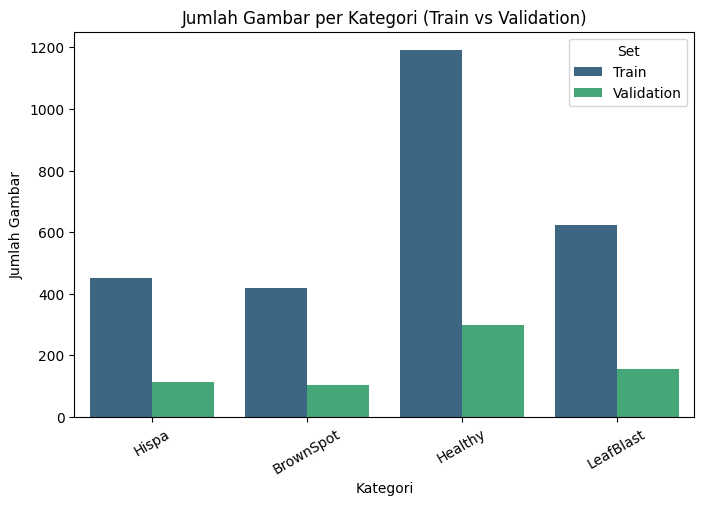


📌 Jumlah Gambar per Kategori:
    Category  Total Images
0      Hispa           565
1  BrownSpot           523
2  LeafBlast           779
3    Healthy          1488

📌 Total Keseluruhan Gambar dalam Dataset: 3355


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_dir = "/content/riceleafs/RiceLeafs"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
def count_images_in_folders(base_dir):
    categories = os.listdir(base_dir)  # Dapatkan daftar kategori
    counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in categories}
    return counts
train_counts = count_images_in_folders(train_dir)
val_counts = count_images_in_folders(val_dir)

# Konversi ke DataFrame untuk visualisasi
df_train = pd.DataFrame(list(train_counts.items()), columns=["Category", "Count"])
df_train["Set"] = "Train"

df_val = pd.DataFrame(list(val_counts.items()), columns=["Category", "Count"])
df_val["Set"] = "Validation"

# Gabungkan kedua DataFrame
df = pd.concat([df_train, df_val])

plt.figure(figsize=(8, 5))
sns.barplot(x="Category", y="Count", hue="Set", data=df, palette="viridis")

# Tambahkan judul dan label
plt.title("Jumlah Gambar per Kategori (Train vs Validation)")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=30)  # Miringkan teks kategori agar lebih terbaca

# Tampilkan plot
plt.show()

# Gabungkan jumlah gambar dari Train dan Validation
total_counts = {category: train_counts.get(category, 0) + val_counts.get(category, 0)
                for category in set(train_counts) | set(val_counts)}

# Konversi ke DataFrame
df_summary = pd.DataFrame(total_counts.items(), columns=["Category", "Total Images"])
print("\n📌 Jumlah Gambar per Kategori:")
print(df_summary)

# Hitung total keseluruhan gambar dalam dataset
total_images = sum(total_counts.values())
print("\n📌 Total Keseluruhan Gambar dalam Dataset:", total_images)


Mounted at /content/drive
🔄 Melakukan augmentasi karena dataset belum tersedia...

🔄 Oversampling untuk kategori: Hispa (Jumlah awal: 457, Target: 1191)



🔹 Augmenting Hispa: 100%|██████████| 734/734 [19:52<00:00,  1.63s/it]



🔄 Oversampling untuk kategori: BrownSpot (Jumlah awal: 418, Target: 1191)



🔹 Augmenting BrownSpot: 100%|██████████| 773/773 [19:13<00:00,  1.49s/it]



🔄 Oversampling untuk kategori: LeafBlast (Jumlah awal: 623, Target: 1191)



🔹 Augmenting LeafBlast: 100%|██████████| 568/568 [10:26<00:00,  1.10s/it]


✅ Augmentasi selesai dalam 2973.10 detik!
✅ File log dan daftar gambar telah disimpan ke Google Drive!


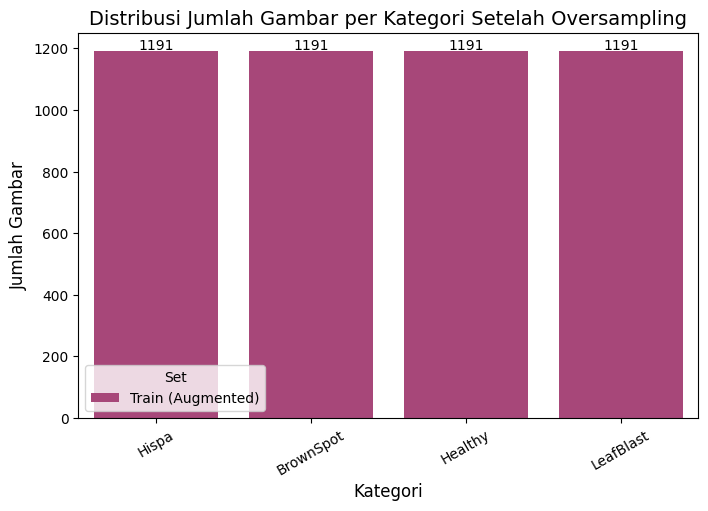

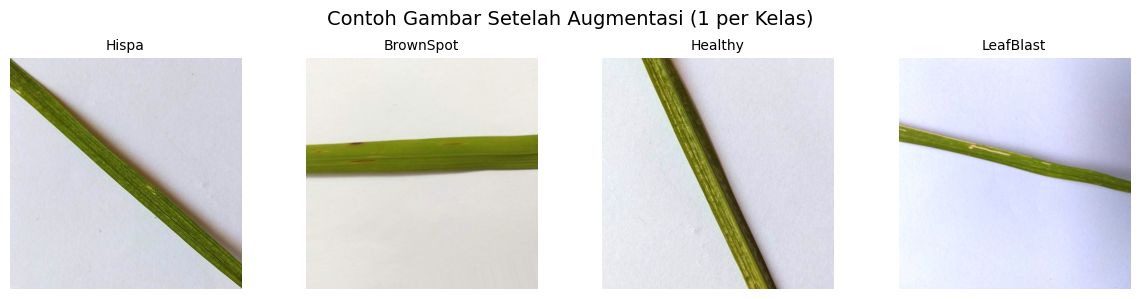

In [6]:
import os
import json
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.callbacks import CSVLogger
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

gdrive_dir = "/content/drive/MyDrive/RiceLeaf_Augmented"
os.makedirs(gdrive_dir, exist_ok=True)

# Path dataset
data_dir = "/content/riceleafs/RiceLeafs"
train_dir = os.path.join(data_dir, "train")

def count_images_in_folders(base_dir):
    categories = os.listdir(base_dir)
    counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in categories}
    return counts

def augment_data(category, target_count):
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    print(f"\n🔄 Oversampling untuk kategori: {category} (Jumlah awal: {len(images)}, Target: {target_count})")
    progress_bar = tqdm(total=target_count - len(images), desc=f"🔹 Augmenting {category}")
    while len(os.listdir(category_path)) < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype('uint8')
        new_img_name = f"aug_{len(os.listdir(category_path))}.jpg"
        save_img(os.path.join(category_path, new_img_name), aug_img)
        progress_bar.update(1)
    progress_bar.close()

if os.path.exists("image_list.json"):
    print("📂 Dataset sudah ada, memuat tanpa augmentasi...")
    with open("image_list.json", "r") as f:
        image_data = json.load(f)
    train_counts_after = {category: len(images) for category, images in image_data.items()}
else:
    print("🔄 Melakukan augmentasi karena dataset belum tersedia...")
    datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest'
    )
    train_counts = count_images_in_folders(train_dir)
    max_images = max(train_counts.values())
    csv_logger = CSVLogger("augment_log.csv", append=True)
    df_log = pd.DataFrame(list(train_counts.items()), columns=["Category", "Count"])
    df_log["Stage"] = "Before Augmentation"
    df_log.to_csv("augment_log.csv", mode="w", index=False)
    start_time = time.time()
    for category, count in train_counts.items():
        if count < max_images:
            augment_data(category, max_images)
    end_time = time.time()
    train_counts_after = count_images_in_folders(train_dir)
    df_log_after = pd.DataFrame(list(train_counts_after.items()), columns=["Category", "Count"])
    df_log_after["Stage"] = "After Augmentation"
    df_log_after.to_csv("augment_log.csv", mode="a", index=False, header=False)
    image_data = {category: os.listdir(os.path.join(train_dir, category)) for category in train_counts_after.keys()}
    with open("image_list.json", "w") as f:
        json.dump(image_data, f)
    print(f"✅ Augmentasi selesai dalam {end_time - start_time:.2f} detik!")

# Simpan file ke Google Drive
os.system(f'cp augment_log.csv {gdrive_dir}/augment_log.csv')
os.system(f'cp image_list.json {gdrive_dir}/image_list.json')
print("✅ File log dan daftar gambar telah disimpan ke Google Drive!")

# Plot hasil augmentasi
df_train_after = pd.DataFrame(list(train_counts_after.items()), columns=["Category", "Count"])
df_train_after["Set"] = "Train (Augmented)"
plt.figure(figsize=(8, 5))
sns.barplot(x="Category", y="Count", hue="Set", data=df_train_after, palette="magma")
plt.title("Distribusi Jumlah Gambar per Kategori Setelah Oversampling", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=30)
for i in range(len(df_train_after)):
    plt.text(i, df_train_after.iloc[i, 1] + 5, df_train_after.iloc[i, 1], ha='center', fontsize=10)
plt.show()

# Menampilkan contoh 1 gambar per kelas setelah augmentasi
num_categories = len(train_counts_after)
fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 3, 3))
for i, category in enumerate(train_counts_after.keys()):
    category_path = os.path.join(train_dir, category)
    sample_img_name = random.choice(os.listdir(category_path))
    sample_img = load_img(os.path.join(category_path, sample_img_name))
    axes[i].imshow(sample_img)
    axes[i].set_title(category, fontsize=10)
    axes[i].axis("off")
plt.suptitle("Contoh Gambar Setelah Augmentasi (1 per Kelas)", fontsize=14)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

# Load CSV log
df_log = pd.read_csv("augment_log.csv")

print(df_log[df_log["Stage"] == "Before Augmentation"])
print(df_log[df_log["Stage"] == "After Augmentation"])



    Category  Count                Stage
0      Hispa    457  Before Augmentation
1  BrownSpot    418  Before Augmentation
2    Healthy   1191  Before Augmentation
3  LeafBlast    623  Before Augmentation
    Category  Count               Stage
4      Hispa   1191  After Augmentation
5  BrownSpot   1191  After Augmentation
6    Healthy   1191  After Augmentation
7  LeafBlast   1191  After Augmentation


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

# Path dataset
DATASET_PATH = "/content/riceleafs/RiceLeafs/train"
GDRIVE_PATH = "/content/drive/MyDrive/mobilenetv2_riceleafs/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Dapatkan daftar folder kelas lebih awal
class_names = os.listdir(DATASET_PATH)
num_classes = len(class_names)  # ⬅️ Pindahkan ini ke sini!

# Pastikan NUM_FOLDS dideklarasikan setelah num_classes tersedia
NUM_FOLDS = min(5, num_classes)

# Buat folder jika belum ada
os.makedirs(GDRIVE_PATH, exist_ok=True)

# Data Generator dengan validation split
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# K-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Dapatkan daftar folder kelas
class_names = os.listdir(DATASET_PATH)
num_classes = len(class_names)

fold_no = 1
all_histories = []
all_accuracies = []

for train_index, val_index in kf.split(class_names):
    print(f"Training Fold {fold_no}...")

    # Data Generator untuk fold ini
    train_generator = data_gen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = data_gen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Load model MobileNetV2
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Bekukan base model

    # Tambahkan layer kustom
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Buat model
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1
    )

    all_histories.append(history.history)
    all_accuracies.append(max(history.history['val_accuracy']))

    # Simpan model untuk setiap fold ke Google Drive
    model.save(f"{GDRIVE_PATH}mobilenetv2_riceleafs_fold{fold_no}.h5")
    print(f"✅ Model untuk Fold {fold_no} telah disimpan di Google Drive!")

    fold_no += 1

# Rata-rata akurasi dari 5-Fold
mean_accuracy = np.mean(all_accuracies)
print(f"Rata-rata Akurasi dari {NUM_FOLDS}-Fold Cross Validation: {mean_accuracy:.4f}")

# Visualisasi hasil training
def plot_learning_curves(histories, num_folds):
    plt.figure(figsize=(12, 5))

    for i, history in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label=f'Fold {i+1}')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['val_accuracy'], label=f'Fold {i+1}')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

plot_learning_curves(all_histories, NUM_FOLDS)



Training Fold 1...
Found 3812 images belonging to 4 classes.
Found 952 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.3256 - loss: 1.5053 - val_accuracy: 0.4947 - val_loss: 1.0591
Epoch 2/10
 81/120 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - accuracy: 0.5130 - loss: 1.1154